# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

2.0.2


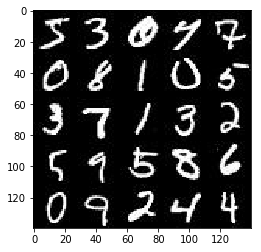

In [3]:
show_n_images = 25
import matplotlib
print(matplotlib.__version__)
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

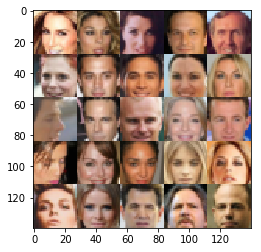

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32,(None,*(image_width,image_height,image_channels)))
    z_input = tf.placeholder(tf.float32,(None,z_dim))
    learning_rate = tf.placeholder(tf.float16,None)

    return real_input, z_input, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('discriminator',reuse= reuse):
        #14*14*64,first convolutional layer
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        conv1 = tf.maximum(alpha*conv1,conv1)
        
        #7*7*128,second convlutional layer
        conv2 = tf.layers.conv2d(conv1,128,5,strides=2,padding='same')
        conv2 = tf.layers.batch_normalization(conv2,training=True)
        conv2 = tf.maximum(alpha*conv2,conv2)
        
        #4*4*256,third convlutional layer
        conv3 = tf.layers.conv2d(conv2,256,5,strides=2,padding='valid')
        conv2 = tf.layers.batch_normalization(conv3,training=True)
        conv3 = tf.maximum(alpha*conv3,conv3)
        
        #flatten
        flat = tf.reshape(conv3,(-1,4*4*256))
        logit = tf.layers.dense(flat,1)
        output= tf.sigmoid(logit)
        
        
        
        
    return output, logit

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.2
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=not is_train):
        #full connection layer
        x = tf.layers.dense(z,7*7*256)
        #reshape to start convolution
        x = tf.reshape(x,(-1,7,7,256))
        x = tf.layers.batch_normalization(x,training=is_train)
        x = tf.maximum(alpha*x,x)  
        
        
        #7*7*128,conv1
        conv1 = tf.layers.conv2d_transpose(x,128,5,strides=1,padding='same')
        conv1 = tf.layers.batch_normalization(conv1,training=is_train)
        conv1 = tf.maximum(alpha*conv1,conv1)  
        
        #14*14*64,conv2
        conv2 = tf.layers.conv2d_transpose(conv1,64,5,strides=2,padding='same')
        conv2 = tf.layers.batch_normalization(conv2,training=is_train)
        conv2 = tf.maximum(alpha*conv2,conv2)  
        
        # Output layer
        #28*28*N
        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 5, strides=2, padding='same')      
        output = 0.5*tf.tanh(logits)
        
    return output
   
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z,out_channel_dim,is_train=True)
    
    d_model_real,d_logits_real = discriminator(input_real,reuse=False)
    d_model_fake,d_logits_fake = discriminator(g_model,reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_fake + d_loss_real
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_var = tf.trainable_variables()
    d_var = [var for var in t_var if var.name.startswith('discriminator')]
    g_var = [var for var in t_var if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss,var_list=d_var)
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss,var_list=g_var)
    
    return d_train_opt, g_train_opt
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #print(data_shape)
    #data_shape [sample,width,height,channel]
    width = data_shape[1]
    height = data_shape[2]
    channel = data_shape[3]
    input_real, input_z, lr = model_inputs(width,height,channel, z_dim)        
    d_loss,g_loss = model_loss(input_real,input_z,channel)      
    d_opt,g_opt = model_opt(d_loss, g_loss,lr, beta1)
    
    steps = 0
    print_every = 50
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1            
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z,lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images,lr:learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps% show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channel, data_image_mode)
                    
                    

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 0/2... Discriminator Loss: 0.8487... Generator Loss: 4.1748
Epoch 0/2... Discriminator Loss: 1.0409... Generator Loss: 1.1588


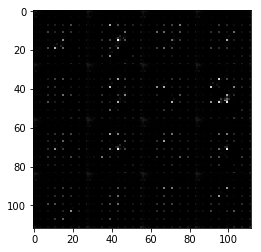

Epoch 0/2... Discriminator Loss: 1.5469... Generator Loss: 0.4752
Epoch 0/2... Discriminator Loss: 0.6798... Generator Loss: 1.8440


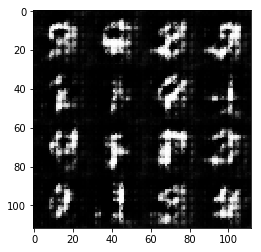

Epoch 0/2... Discriminator Loss: 0.5756... Generator Loss: 2.1459
Epoch 0/2... Discriminator Loss: 0.8385... Generator Loss: 1.8672


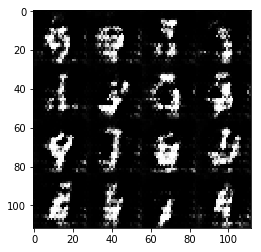

Epoch 0/2... Discriminator Loss: 1.4113... Generator Loss: 0.3666
Epoch 0/2... Discriminator Loss: 1.8149... Generator Loss: 0.3051


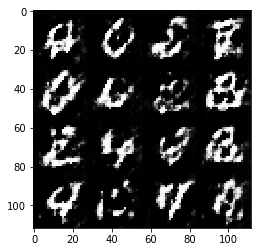

Epoch 0/2... Discriminator Loss: 0.7530... Generator Loss: 1.2139
Epoch 0/2... Discriminator Loss: 0.7423... Generator Loss: 1.0741


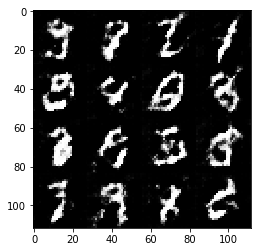

Epoch 0/2... Discriminator Loss: 0.7856... Generator Loss: 2.1456
Epoch 0/2... Discriminator Loss: 1.3583... Generator Loss: 0.4972


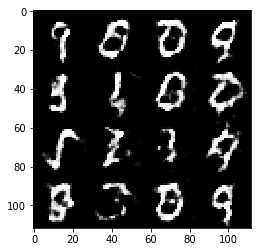

Epoch 0/2... Discriminator Loss: 1.5566... Generator Loss: 0.3086
Epoch 0/2... Discriminator Loss: 0.6458... Generator Loss: 1.1918


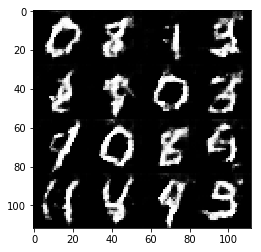

Epoch 0/2... Discriminator Loss: 0.8269... Generator Loss: 1.1922
Epoch 0/2... Discriminator Loss: 1.9833... Generator Loss: 0.2300


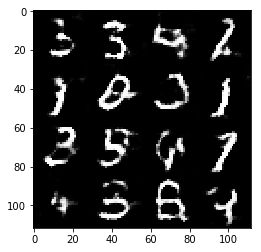

Epoch 0/2... Discriminator Loss: 1.0432... Generator Loss: 0.6610
Epoch 0/2... Discriminator Loss: 0.7966... Generator Loss: 2.2949


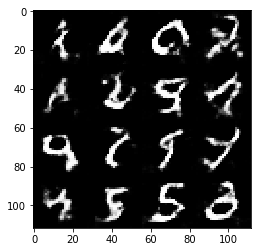

Epoch 0/2... Discriminator Loss: 0.7971... Generator Loss: 1.5729
Epoch 0/2... Discriminator Loss: 0.6033... Generator Loss: 1.3775


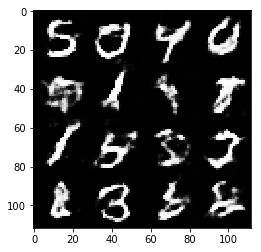

Epoch 0/2... Discriminator Loss: 0.8847... Generator Loss: 0.7860
Epoch 0/2... Discriminator Loss: 1.6283... Generator Loss: 0.2643


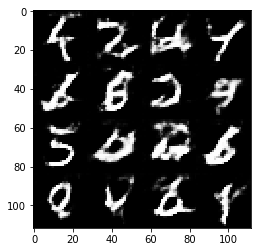

Epoch 0/2... Discriminator Loss: 0.4373... Generator Loss: 2.3169
Epoch 0/2... Discriminator Loss: 0.9568... Generator Loss: 0.6037


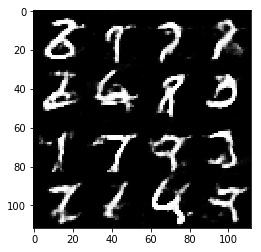

Epoch 0/2... Discriminator Loss: 0.5114... Generator Loss: 1.6816
Epoch 0/2... Discriminator Loss: 1.5024... Generator Loss: 0.2993


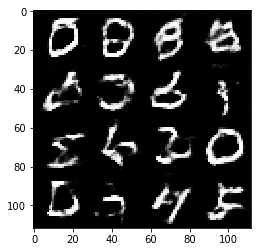

Epoch 0/2... Discriminator Loss: 1.1746... Generator Loss: 0.5710
Epoch 0/2... Discriminator Loss: 1.5921... Generator Loss: 0.2771


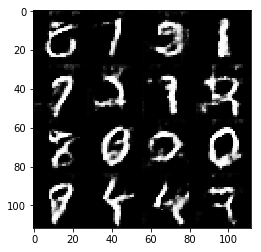

Epoch 0/2... Discriminator Loss: 0.6612... Generator Loss: 0.9724
Epoch 0/2... Discriminator Loss: 0.3442... Generator Loss: 2.1951


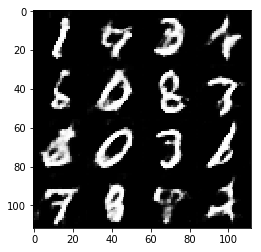

Epoch 0/2... Discriminator Loss: 0.9597... Generator Loss: 0.5502
Epoch 0/2... Discriminator Loss: 1.7661... Generator Loss: 0.2883


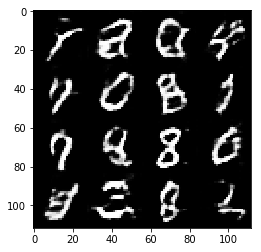

Epoch 0/2... Discriminator Loss: 0.5046... Generator Loss: 1.3093
Epoch 0/2... Discriminator Loss: 0.5055... Generator Loss: 1.3178


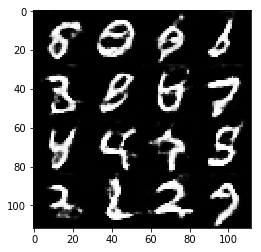

Epoch 0/2... Discriminator Loss: 0.6805... Generator Loss: 1.1526
Epoch 0/2... Discriminator Loss: 0.3307... Generator Loss: 1.9573


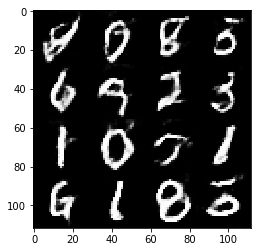

Epoch 0/2... Discriminator Loss: 1.2054... Generator Loss: 0.4913
Epoch 1/2... Discriminator Loss: 0.4941... Generator Loss: 1.4797


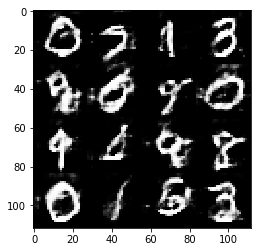

Epoch 1/2... Discriminator Loss: 0.3485... Generator Loss: 1.8726
Epoch 1/2... Discriminator Loss: 0.2980... Generator Loss: 1.7517


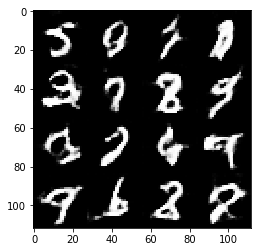

Epoch 1/2... Discriminator Loss: 0.6328... Generator Loss: 1.8032
Epoch 1/2... Discriminator Loss: 2.2277... Generator Loss: 0.1390


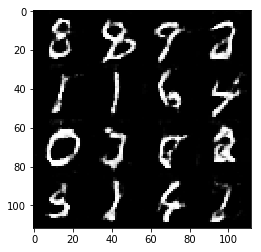

Epoch 1/2... Discriminator Loss: 1.2409... Generator Loss: 0.4844
Epoch 1/2... Discriminator Loss: 0.6857... Generator Loss: 2.5608


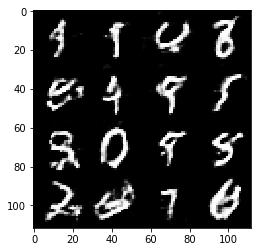

Epoch 1/2... Discriminator Loss: 0.5127... Generator Loss: 1.3365
Epoch 1/2... Discriminator Loss: 1.3237... Generator Loss: 0.3919


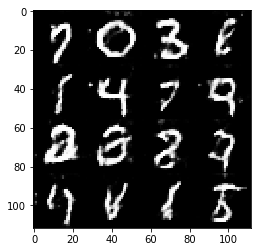

Epoch 1/2... Discriminator Loss: 0.3849... Generator Loss: 3.4288
Epoch 1/2... Discriminator Loss: 1.7840... Generator Loss: 0.3868


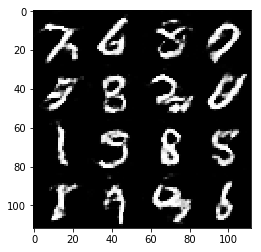

Epoch 1/2... Discriminator Loss: 1.6531... Generator Loss: 0.4139
Epoch 1/2... Discriminator Loss: 1.7480... Generator Loss: 0.2505


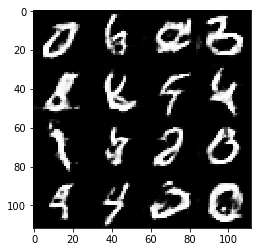

Epoch 1/2... Discriminator Loss: 1.1667... Generator Loss: 0.6196
Epoch 1/2... Discriminator Loss: 0.2355... Generator Loss: 2.0898


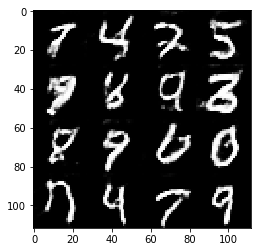

Epoch 1/2... Discriminator Loss: 1.2392... Generator Loss: 0.5097
Epoch 1/2... Discriminator Loss: 0.9459... Generator Loss: 1.0072


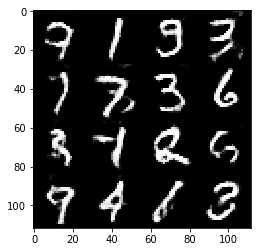

Epoch 1/2... Discriminator Loss: 1.3063... Generator Loss: 0.3613
Epoch 1/2... Discriminator Loss: 0.8445... Generator Loss: 2.1324


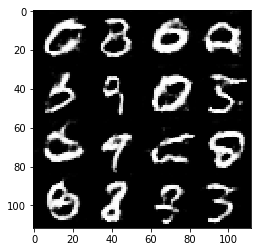

Epoch 1/2... Discriminator Loss: 1.9868... Generator Loss: 0.2465
Epoch 1/2... Discriminator Loss: 0.6558... Generator Loss: 1.3482


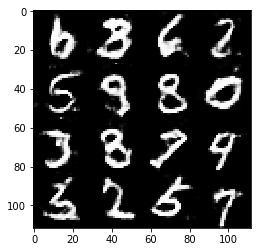

Epoch 1/2... Discriminator Loss: 0.4669... Generator Loss: 2.2659
Epoch 1/2... Discriminator Loss: 0.4603... Generator Loss: 1.4780


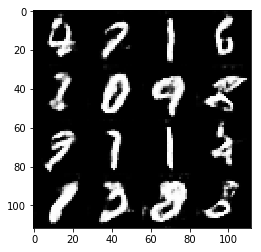

Epoch 1/2... Discriminator Loss: 0.9464... Generator Loss: 0.7667
Epoch 1/2... Discriminator Loss: 0.5373... Generator Loss: 2.0273


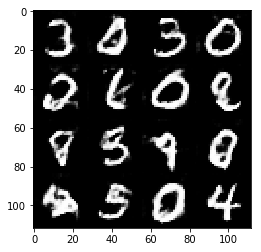

Epoch 1/2... Discriminator Loss: 0.5717... Generator Loss: 1.2312
Epoch 1/2... Discriminator Loss: 0.4010... Generator Loss: 2.3142


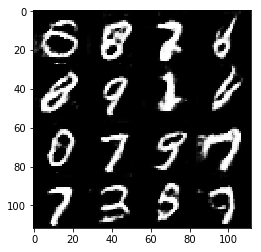

Epoch 1/2... Discriminator Loss: 1.0199... Generator Loss: 0.6028
Epoch 1/2... Discriminator Loss: 0.9000... Generator Loss: 1.0645


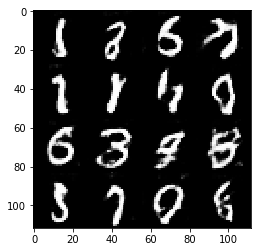

Epoch 1/2... Discriminator Loss: 0.5252... Generator Loss: 1.4672
Epoch 1/2... Discriminator Loss: 0.5818... Generator Loss: 1.5250


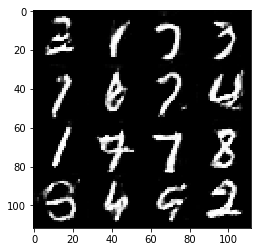

Epoch 1/2... Discriminator Loss: 1.2426... Generator Loss: 0.6324
Epoch 1/2... Discriminator Loss: 1.2840... Generator Loss: 0.5535


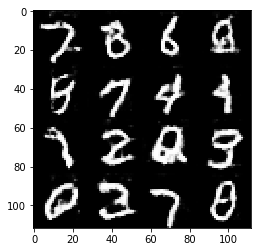

Epoch 1/2... Discriminator Loss: 0.2902... Generator Loss: 1.8960
Epoch 1/2... Discriminator Loss: 1.0717... Generator Loss: 0.8752


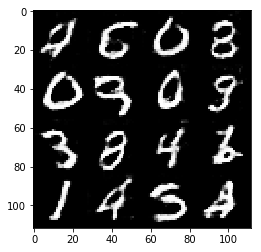

Epoch 1/2... Discriminator Loss: 0.9775... Generator Loss: 0.8784
Epoch 1/2... Discriminator Loss: 0.7026... Generator Loss: 0.9142


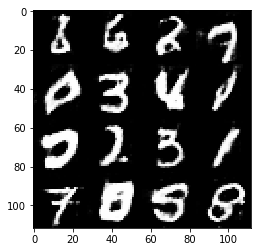

Epoch 1/2... Discriminator Loss: 1.1192... Generator Loss: 0.4980


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 0/1... Discriminator Loss: 0.6095... Generator Loss: 1.8145
Epoch 0/1... Discriminator Loss: 0.8526... Generator Loss: 2.5513


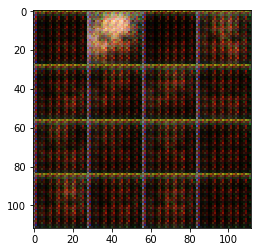

Epoch 0/1... Discriminator Loss: 0.8853... Generator Loss: 0.7814
Epoch 0/1... Discriminator Loss: 1.2417... Generator Loss: 0.7352


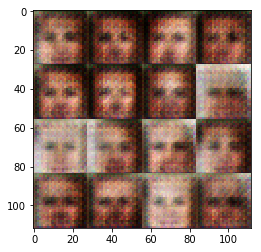

Epoch 0/1... Discriminator Loss: 1.2838... Generator Loss: 0.4994
Epoch 0/1... Discriminator Loss: 2.4643... Generator Loss: 4.4124


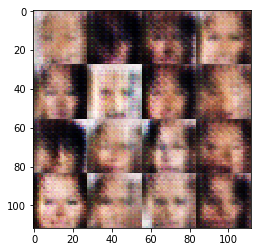

Epoch 0/1... Discriminator Loss: 1.5194... Generator Loss: 0.3496
Epoch 0/1... Discriminator Loss: 1.8557... Generator Loss: 0.2419


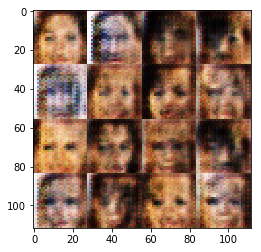

Epoch 0/1... Discriminator Loss: 0.5991... Generator Loss: 1.1242
Epoch 0/1... Discriminator Loss: 1.1693... Generator Loss: 0.5459


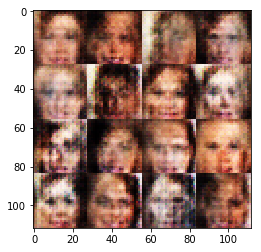

Epoch 0/1... Discriminator Loss: 1.2499... Generator Loss: 0.4693
Epoch 0/1... Discriminator Loss: 1.1176... Generator Loss: 0.9161


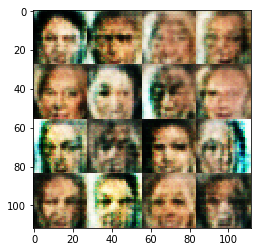

Epoch 0/1... Discriminator Loss: 1.2260... Generator Loss: 1.1863
Epoch 0/1... Discriminator Loss: 0.9200... Generator Loss: 0.9694


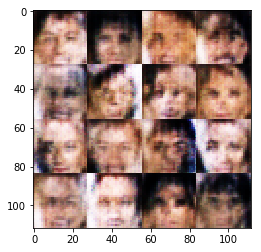

Epoch 0/1... Discriminator Loss: 0.9264... Generator Loss: 0.7897
Epoch 0/1... Discriminator Loss: 1.1019... Generator Loss: 0.8047


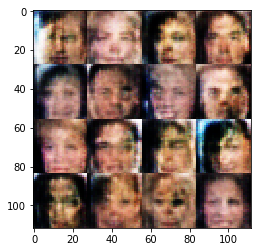

Epoch 0/1... Discriminator Loss: 1.0928... Generator Loss: 0.8150
Epoch 0/1... Discriminator Loss: 1.6351... Generator Loss: 0.2831


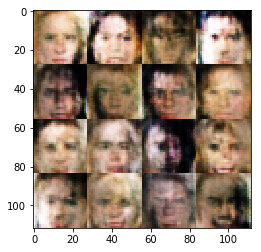

Epoch 0/1... Discriminator Loss: 1.1680... Generator Loss: 0.7416
Epoch 0/1... Discriminator Loss: 1.2207... Generator Loss: 0.5714


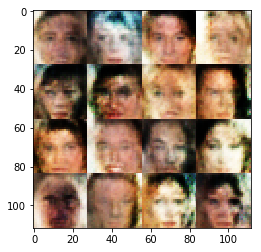

Epoch 0/1... Discriminator Loss: 1.1306... Generator Loss: 0.5893
Epoch 0/1... Discriminator Loss: 1.2993... Generator Loss: 0.7401


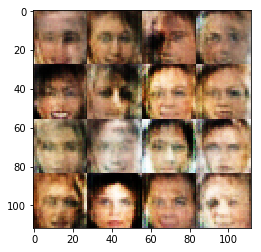

Epoch 0/1... Discriminator Loss: 1.2719... Generator Loss: 0.9537
Epoch 0/1... Discriminator Loss: 1.3095... Generator Loss: 0.6901


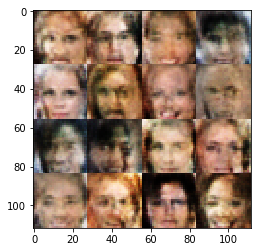

Epoch 0/1... Discriminator Loss: 1.1255... Generator Loss: 0.6444
Epoch 0/1... Discriminator Loss: 1.1597... Generator Loss: 0.6020


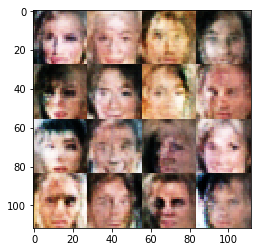

Epoch 0/1... Discriminator Loss: 1.0509... Generator Loss: 0.7318
Epoch 0/1... Discriminator Loss: 1.0580... Generator Loss: 1.8106


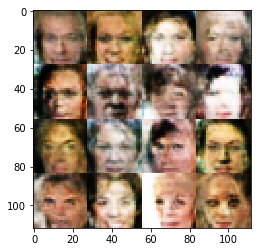

Epoch 0/1... Discriminator Loss: 1.3907... Generator Loss: 0.4577
Epoch 0/1... Discriminator Loss: 1.2900... Generator Loss: 0.5290


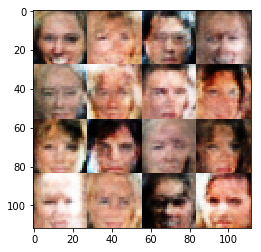

Epoch 0/1... Discriminator Loss: 1.3325... Generator Loss: 0.4780
Epoch 0/1... Discriminator Loss: 1.7203... Generator Loss: 0.3217


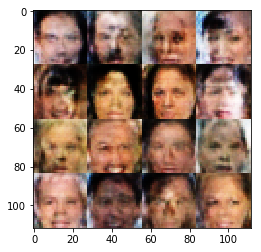

Epoch 0/1... Discriminator Loss: 1.3941... Generator Loss: 0.5409
Epoch 0/1... Discriminator Loss: 1.1418... Generator Loss: 0.5159


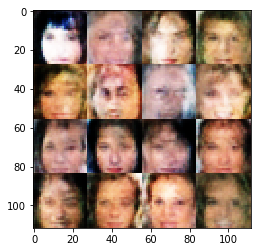

Epoch 0/1... Discriminator Loss: 0.9065... Generator Loss: 1.0117
Epoch 0/1... Discriminator Loss: 1.1774... Generator Loss: 2.0249


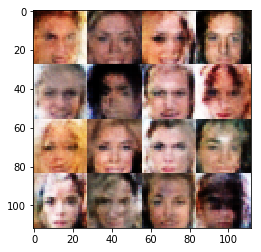

Epoch 0/1... Discriminator Loss: 0.8241... Generator Loss: 0.9248
Epoch 0/1... Discriminator Loss: 1.5236... Generator Loss: 0.3157


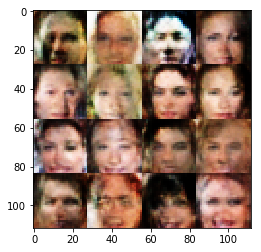

Epoch 0/1... Discriminator Loss: 1.0417... Generator Loss: 0.7252
Epoch 0/1... Discriminator Loss: 1.2985... Generator Loss: 0.4816


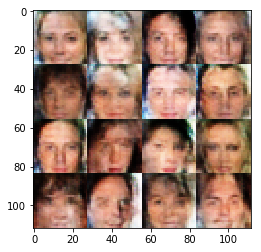

Epoch 0/1... Discriminator Loss: 1.2096... Generator Loss: 0.9803
Epoch 0/1... Discriminator Loss: 1.0937... Generator Loss: 1.3870


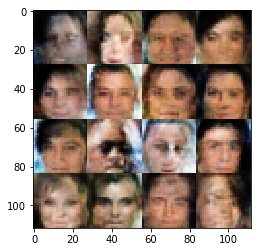

Epoch 0/1... Discriminator Loss: 1.2370... Generator Loss: 1.1067
Epoch 0/1... Discriminator Loss: 0.9361... Generator Loss: 1.2160


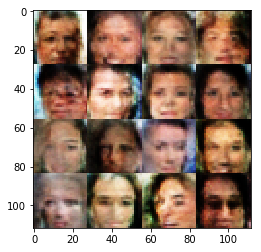

Epoch 0/1... Discriminator Loss: 1.0437... Generator Loss: 0.7515
Epoch 0/1... Discriminator Loss: 0.8616... Generator Loss: 0.9232


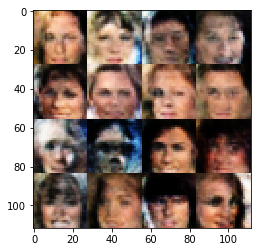

Epoch 0/1... Discriminator Loss: 1.1496... Generator Loss: 0.6180
Epoch 0/1... Discriminator Loss: 0.9631... Generator Loss: 0.5909


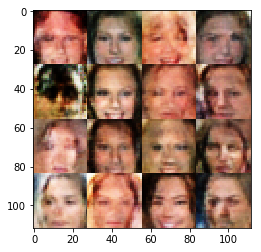

Epoch 0/1... Discriminator Loss: 0.8454... Generator Loss: 1.6208
Epoch 0/1... Discriminator Loss: 1.4530... Generator Loss: 0.3198


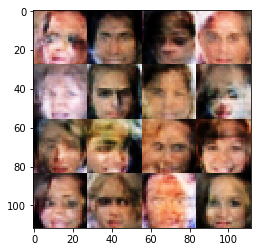

Epoch 0/1... Discriminator Loss: 1.0070... Generator Loss: 0.6295
Epoch 0/1... Discriminator Loss: 1.0383... Generator Loss: 1.5812


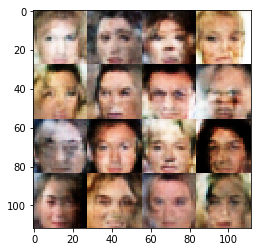

Epoch 0/1... Discriminator Loss: 1.1553... Generator Loss: 0.4698
Epoch 0/1... Discriminator Loss: 1.0948... Generator Loss: 0.5384


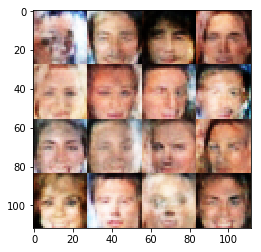

Epoch 0/1... Discriminator Loss: 0.9700... Generator Loss: 0.6095
Epoch 0/1... Discriminator Loss: 0.9702... Generator Loss: 1.5119


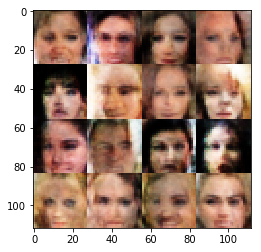

Epoch 0/1... Discriminator Loss: 0.9571... Generator Loss: 0.7595
Epoch 0/1... Discriminator Loss: 1.0326... Generator Loss: 2.0103


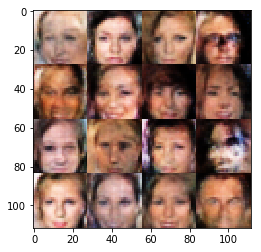

Epoch 0/1... Discriminator Loss: 0.7081... Generator Loss: 2.2345
Epoch 0/1... Discriminator Loss: 3.6360... Generator Loss: 0.0345


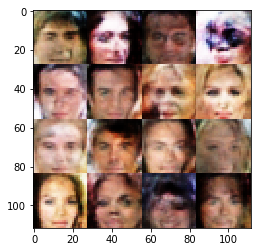

Epoch 0/1... Discriminator Loss: 0.8710... Generator Loss: 1.0633
Epoch 0/1... Discriminator Loss: 0.9808... Generator Loss: 0.6483


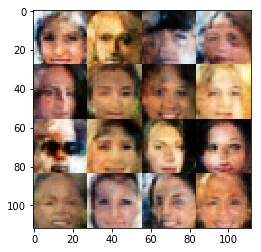

Epoch 0/1... Discriminator Loss: 2.6442... Generator Loss: 4.1979
Epoch 0/1... Discriminator Loss: 1.6406... Generator Loss: 0.2785


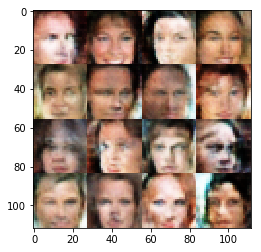

Epoch 0/1... Discriminator Loss: 0.9321... Generator Loss: 2.1803
Epoch 0/1... Discriminator Loss: 0.9878... Generator Loss: 0.6478


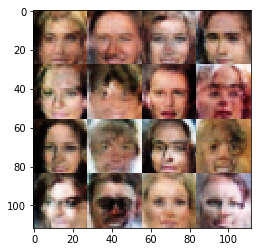

Epoch 0/1... Discriminator Loss: 1.0829... Generator Loss: 0.6598
Epoch 0/1... Discriminator Loss: 1.5173... Generator Loss: 0.4229


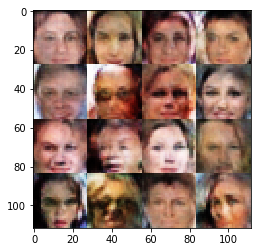

Epoch 0/1... Discriminator Loss: 0.9050... Generator Loss: 1.6684
Epoch 0/1... Discriminator Loss: 1.6742... Generator Loss: 0.2682


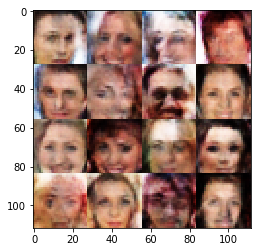

Epoch 0/1... Discriminator Loss: 4.3666... Generator Loss: 3.4322
Epoch 0/1... Discriminator Loss: 0.7475... Generator Loss: 1.5461


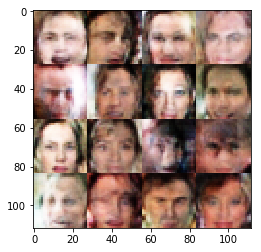

Epoch 0/1... Discriminator Loss: 0.7330... Generator Loss: 1.6134
Epoch 0/1... Discriminator Loss: 0.4873... Generator Loss: 1.4248


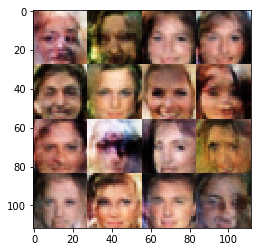

Epoch 0/1... Discriminator Loss: 0.7164... Generator Loss: 1.1494
Epoch 0/1... Discriminator Loss: 0.8469... Generator Loss: 2.0008


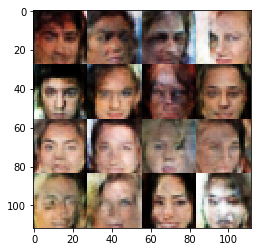

Epoch 0/1... Discriminator Loss: 0.8320... Generator Loss: 1.1162
Epoch 0/1... Discriminator Loss: 0.7448... Generator Loss: 0.9600


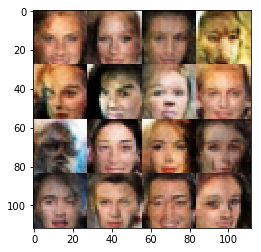

Epoch 0/1... Discriminator Loss: 1.0051... Generator Loss: 0.6047
Epoch 0/1... Discriminator Loss: 0.6115... Generator Loss: 1.0523


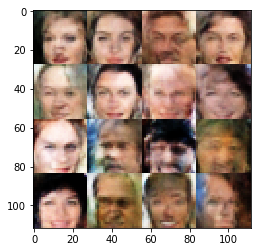

Epoch 0/1... Discriminator Loss: 0.8299... Generator Loss: 0.7205
Epoch 0/1... Discriminator Loss: 0.6949... Generator Loss: 2.1395


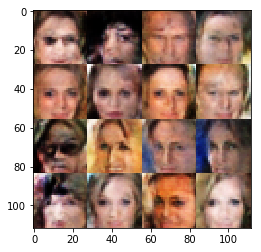

Epoch 0/1... Discriminator Loss: 1.3171... Generator Loss: 0.3635
Epoch 0/1... Discriminator Loss: 0.5919... Generator Loss: 1.8455


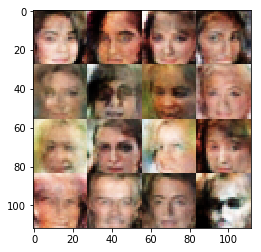

Epoch 0/1... Discriminator Loss: 0.5660... Generator Loss: 1.8556
Epoch 0/1... Discriminator Loss: 0.6230... Generator Loss: 0.9896


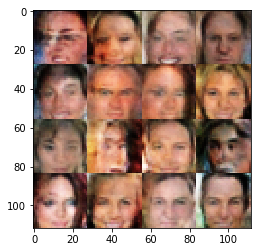

Epoch 0/1... Discriminator Loss: 0.7858... Generator Loss: 0.9226
Epoch 0/1... Discriminator Loss: 0.5438... Generator Loss: 1.9514


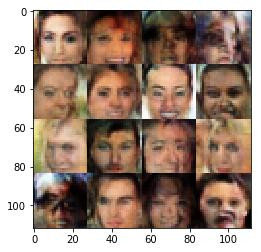

Epoch 0/1... Discriminator Loss: 1.1304... Generator Loss: 0.7362
Epoch 0/1... Discriminator Loss: 0.4312... Generator Loss: 1.8491


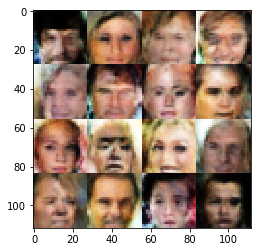

Epoch 0/1... Discriminator Loss: 0.6340... Generator Loss: 1.0796
Epoch 0/1... Discriminator Loss: 0.3655... Generator Loss: 1.7307


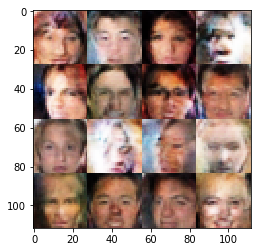

Epoch 0/1... Discriminator Loss: 0.7646... Generator Loss: 0.9873
Epoch 0/1... Discriminator Loss: 0.7789... Generator Loss: 0.9692


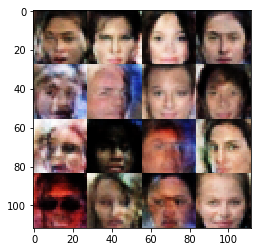

Epoch 0/1... Discriminator Loss: 0.9427... Generator Loss: 0.7430
Epoch 0/1... Discriminator Loss: 0.7350... Generator Loss: 1.1804


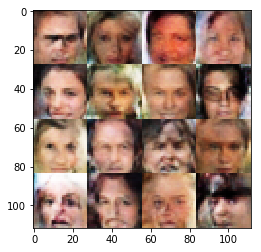

Epoch 0/1... Discriminator Loss: 1.2332... Generator Loss: 0.4818
Epoch 0/1... Discriminator Loss: 1.0291... Generator Loss: 0.6437


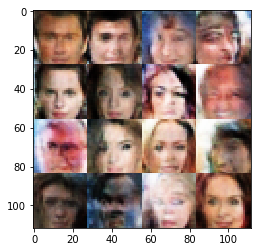

Epoch 0/1... Discriminator Loss: 0.6713... Generator Loss: 0.9505
Epoch 0/1... Discriminator Loss: 1.0466... Generator Loss: 0.7471


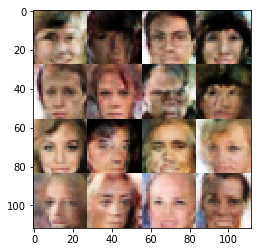

Epoch 0/1... Discriminator Loss: 1.9351... Generator Loss: 0.2100
Epoch 0/1... Discriminator Loss: 0.8847... Generator Loss: 0.7458


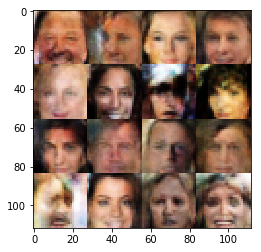

Epoch 0/1... Discriminator Loss: 1.5313... Generator Loss: 0.4505
Epoch 0/1... Discriminator Loss: 1.1108... Generator Loss: 0.5110


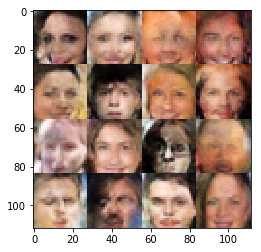

Epoch 0/1... Discriminator Loss: 0.6128... Generator Loss: 1.0887
Epoch 0/1... Discriminator Loss: 0.7228... Generator Loss: 0.9396


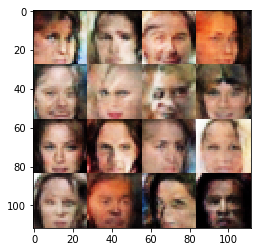

Epoch 0/1... Discriminator Loss: 0.5393... Generator Loss: 1.9365
Epoch 0/1... Discriminator Loss: 0.8076... Generator Loss: 2.1030


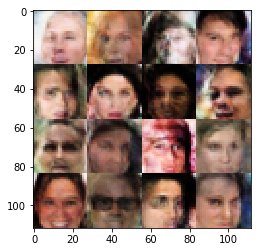

Epoch 0/1... Discriminator Loss: 0.7569... Generator Loss: 0.9129
Epoch 0/1... Discriminator Loss: 0.7264... Generator Loss: 3.4464


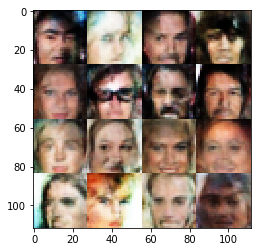

Epoch 0/1... Discriminator Loss: 0.5204... Generator Loss: 1.7086
Epoch 0/1... Discriminator Loss: 0.5667... Generator Loss: 1.3201


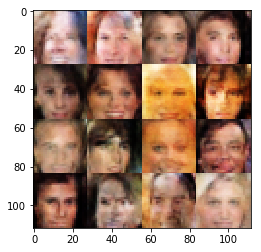

Epoch 0/1... Discriminator Loss: 2.4239... Generator Loss: 0.1567
Epoch 0/1... Discriminator Loss: 0.4860... Generator Loss: 1.3846


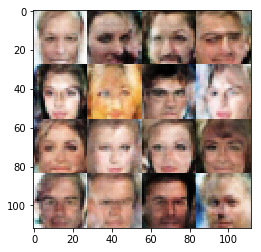

Epoch 0/1... Discriminator Loss: 1.2706... Generator Loss: 1.7269
Epoch 0/1... Discriminator Loss: 0.8938... Generator Loss: 2.2802


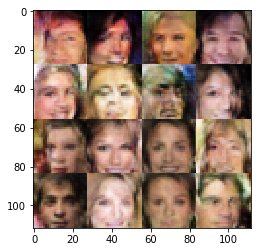

Epoch 0/1... Discriminator Loss: 0.7677... Generator Loss: 1.2181
Epoch 0/1... Discriminator Loss: 0.9284... Generator Loss: 0.6708


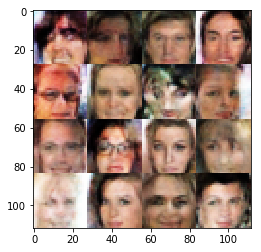

Epoch 0/1... Discriminator Loss: 0.9897... Generator Loss: 0.6419
Epoch 0/1... Discriminator Loss: 0.9273... Generator Loss: 3.4729


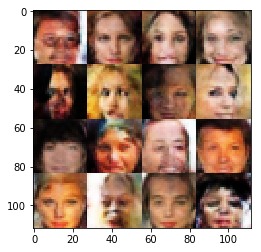

Epoch 0/1... Discriminator Loss: 0.6897... Generator Loss: 3.7706
Epoch 0/1... Discriminator Loss: 1.4227... Generator Loss: 0.3841


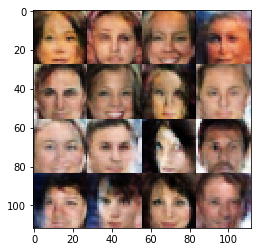

Epoch 0/1... Discriminator Loss: 0.8250... Generator Loss: 0.7192
Epoch 0/1... Discriminator Loss: 0.5093... Generator Loss: 1.3885


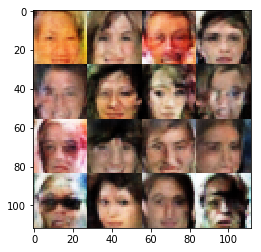

Epoch 0/1... Discriminator Loss: 0.5457... Generator Loss: 1.1892
Epoch 0/1... Discriminator Loss: 0.7266... Generator Loss: 2.0217


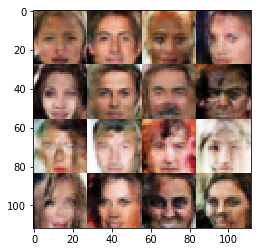

In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。